In [186]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import gzip
import copy
import pickle as pk

import networkx as nx
from networkx.algorithms import bipartite, components, shortest_paths

# Importing the datasets, cleaning, transforming

## Import

**Instacart datasets** (provided) : https://www.instacart.com/datasets/grocery-shopping-2017 . The instacart datasets consist in a group of 5 different datasets, each adopting a different point of view 
* "products", a dataset based on the product point of view, describing to which aisle and department it belongs to
* "aisles", a dataset that enriches "products" by describing each aisle formally
* "departments", a dataset that enriches "products" by describing each department formally
* "orders", a dataset based on the order point of view, describing when it was purchased
* "order_products_prior", a dataset based on both the order and product point of view, associating each order with the products that were purchased

After loading the datasets, we verify whether there are any missing values. 

In [2]:
products = pd.read_csv('data/products.csv', sep=',')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [3]:
products.isnull().values.any()

False

In [4]:
aisles = pd.read_csv('data/aisles.csv', sep=',')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [5]:
aisles.isnull().values.any()

False

In [6]:
aisles.size

268

In [7]:
departments = pd.read_csv('data/departments.csv', sep=',')
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [8]:
departments.isnull().values.any()

False

In [9]:
print(departments.size)
departments.head(50)

42


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


In [10]:
orders = pd.read_csv('data/orders.csv', sep=',')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [11]:
orders.isnull().values.sum()==orders['days_since_prior_order'].isnull().values.sum()

True

In [12]:
orders.size

23947581

The missing values in _orders_ appear to correspond to the date of "previous order", when it happens to be the first one.

In [13]:
history = pd.read_csv('data/order_products__prior.csv', sep=',')
history.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [14]:
history.isnull().values.any()

False

There are no unexpected NaN values in any of the Instacart datasets.

## Gathering all datasets

**Create a dataset with all useful information gathered : products_litteral**

We first add the names of the aisle and department in the _products_ dataset, instead of the ID, by merging the datasets :

In [15]:
products_litteral = pd.merge(pd.merge(products, aisles, on='aisle_id'), departments, on='department_id').drop(['aisle_id', 'department_id'], axis=1)
products_litteral.head()

,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks
2,102,Danish Butter Cookies,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks


In [16]:
nb_prods_per_dept = products_litteral.groupby('department').count().sort_values(by='product_id')
nb_prods_per_dept.head(50)

,product_id,product_name,aisle
department,,,
bulk,38,38,38
other,548,548,548
meat seafood,907,907,907
pets,972,972,972
alcohol,1054,1054,1054
babies,1081,1081,1081
breakfast,1115,1115,1115
international,1139,1139,1139
missing,1258,1258,1258


In [17]:
food_depts = ['bulk', 'meat seafood', 'snacks', 'beverages', 'frozen', 'dairy eggs', 'canned goods', 'dry goods pasta', 'produce', 'bakery', 'deli', 'breakfast', 'alcohol', 'pantry', 'international']

In [18]:
by_dept = {}
for dept in food_depts:
    by_dept[dept] = products_litteral[products_litteral.department==dept]

In [19]:
products_litteral[products_litteral.department=='deli'].head(50)

,product_id,product_name,aisle,department
45210,49,Vegetarian Grain Meat Sausages Italian - 4 CT,tofu meat alternatives,deli
45211,74,Artisan Chick'n & Apple Sausage,tofu meat alternatives,deli
45212,616,Silken Tofu,tofu meat alternatives,deli
45213,731,Wild Mushroom Vegetarian Quarter Loaf,tofu meat alternatives,deli
45214,904,"Tofu, Gluten Free, Garlic Pepper",tofu meat alternatives,deli
45215,1455,Firm Pesto Tofu,tofu meat alternatives,deli
45216,1646,Smoked Ham Style Deli Slices,tofu meat alternatives,deli
45217,2344,Organic SprouTofu Savory Baked Tofu,tofu meat alternatives,deli
45218,2791,Organic SprouTofu Hickory BBQ Smoked Tofu,tofu meat alternatives,deli
45219,3174,Sprouted Tofu Plus Organic Super Firm,tofu meat alternatives,deli


**Dealing with 'missing' values**


In [20]:
missing = products_litteral[(products_litteral.department =='missing') | (products_litteral.aisle=='missing')]
missing.head(20)

,product_id,product_name,aisle,department
42813,38,Ultra Antibacterial Dish Liquid,missing,missing
42814,72,Organic Honeycrisp Apples,missing,missing
42815,110,Uncured Turkey Bologna,missing,missing
42816,297,"Write Bros Ball Point Pens, Cap-Pen, Medium (1...",missing,missing
42817,417,Classics Baby Binks Easter Chocolate Bunny,missing,missing
42818,437,Strawberry Cheesecake Nonfat Yogurt,missing,missing
42819,440,Crossovers Olive Thyme Almond,missing,missing
42820,472,Fancy Diced Hot Chilies,missing,missing
42821,491,Pompelmo Water,missing,missing
42822,556,Bake & Break Cheese Garlic Loaf,missing,missing


We can see many products don't have any name for the aisle and/or department

In [21]:
print("There are %d products with 'missing' aisle/department. This represent %0.1f%% of the products." %(missing.shape[0], missing.shape[0]/products_litteral.shape[0]*100))

There are 1258 products with 'missing' aisle/department. This represent 2.5% of the products.


The unlabelled products seem to come from many different categories, and represent a small fraction of our dataset. We decide in a first approach to let them in our work dataset, but to treat them carefully. In further steps, we may remove them or find a way to associate them with their correct aisle and department.

In [22]:
#products_litteral = products_litteral.drop(missing.index)

In [23]:
del(products)
del(missing)

In [24]:
orders_products = pd.merge(orders, history, on='order_id').drop(['add_to_cart_order', 'reordered'], axis=1)

In [25]:
orders_products_by_dept = {}
for dept in food_depts:
    orders_products_by_dept[dept] = pd.merge(orders_products, by_dept[dept], on='product_id')[['user_id', 'product_id', 'order_id', 'product_name']]
    print(orders_products_by_dept[dept].head())

   user_id  product_id  order_id product_name
0       65        5161   3003586  Dried Mango
1       65        5161   1625976  Dried Mango
2       65        5161   2133732  Dried Mango
3       65        5161   1999119  Dried Mango
4       65        5161    225812  Dried Mango
   user_id  product_id  order_id            product_name
0        2          23    788338  Organic Turkey Burgers
1      434          23   1073729  Organic Turkey Burgers
2      643          23   1554027  Organic Turkey Burgers
3      704          23   2376164  Organic Turkey Burgers
4      968          23   1654363  Organic Turkey Burgers
   user_id  product_id  order_id         product_name
0        1       12427   2539329  Original Beef Jerky
1        1       12427   2398795  Original Beef Jerky
2        1       12427    473747  Original Beef Jerky
3        1       12427   2254736  Original Beef Jerky
4        1       12427    431534  Original Beef Jerky
   user_id  product_id  order_id product_name
0        1  

In [26]:
del(orders_products)

In [27]:
orders_users_by_dept = {}
for dept in food_depts:
    orders_users_by_dept[dept] = orders_products_by_dept[dept].groupby(['user_id', 'product_id', 'product_name']).count().rename(columns={'order_id':'nb_orders'})
    print(orders_users_by_dept[dept].head())

                                        nb_orders
user_id product_id product_name                  
65      5161       Dried Mango                 10
68      22260      Organic Rolled Oats          2
138     1000       Apricots                     1
140     1000       Apricots                     5
149     30365      Vegetable Chips              2
                                                      nb_orders
user_id product_id product_name                                
2       23         Organic Turkey Burgers                     1
6       38293      Ground Turkey Breast                       2
7       13198      85% Lean Ground Beef                       8
9       7952       Chicken & Apple Breakfast Sausage          1
10      5646       Organic Turkey Bacon                       1
                                                                       nb_orders
user_id product_id product_name                                                 
1       10258      Pistachios           

In [28]:
products_litteral[products_litteral.aisle == 'packaged produce'].head(50)

,product_id,product_name,aisle,department
42781,1672,English Cucumbers,packaged produce,produce
42782,3265,Mini Seedless Watermelon Pack,packaged produce,produce
42783,4724,Broccoli Florettes,packaged produce,produce
42784,5068,Cauliflower Florets,packaged produce,produce
42785,5985,Red Bell Peppers,packaged produce,produce
42786,6184,Clementines,packaged produce,produce
42787,7252,Deep Green Blends Kale,packaged produce,produce
42788,8048,Packaged Grape Tomatoes,packaged produce,produce
42789,8571,Baby Cucumbers,packaged produce,produce
42790,8803,Fully Husked & Trimmed Super Sweet Corn,packaged produce,produce


In [37]:
products_litteral[products_litteral.aisle == 'soft drinks'].head(50)

,product_id,product_name,aisle,department
15314,73,Jasmine Tea Unfiltered Ginger Ale,soft drinks,beverages
15315,167,Sparkling Blush Grape Juice,soft drinks,beverages
15316,196,Soda,soft drinks,beverages
15317,230,Vanilla Cream Soda,soft drinks,beverages
15318,257,Key Lime Soda,soft drinks,beverages
15319,277,Diet Root Beer,soft drinks,beverages
15320,371,Juniper Berry Soda,soft drinks,beverages
15321,456,Sparkling Blueberry,soft drinks,beverages
15322,530,7UP,soft drinks,beverages
15323,649,Classic coke,soft drinks,beverages


In [30]:
nb_prods_per_dept = products_litteral.groupby('department').count().sort_values(by='product_id')
nb_prods_per_dept.head(50)

,product_id,product_name,aisle
department,,,
bulk,38,38,38
other,548,548,548
meat seafood,907,907,907
pets,972,972,972
alcohol,1054,1054,1054
babies,1081,1081,1081
breakfast,1115,1115,1115
international,1139,1139,1139
missing,1258,1258,1258


## Look inside the snacks department

In [31]:
orders_users_by_dept['snacks'].head()

nb_orders
user_id product_id product_name                                                 
1       10258      Pistachios                                                  9
        12427      Original Beef Jerky                                        10
        26088      Aged White Cheddar Popcorn                                  2
        39657      Milk Chocolate Almonds                                      1
2       5322       Gluten Free Dark Chocolate Chunk Chewy with a C...          1

In [32]:
snacks_orders_users = orders_users_by_dept['snacks'].reset_index()
snacks_orders_users.head(8)

,user_id,product_id,product_name,nb_orders
0,1,10258,Pistachios,9
1,1,12427,Original Beef Jerky,10
2,1,26088,Aged White Cheddar Popcorn,2
3,1,39657,Milk Chocolate Almonds,1
4,2,5322,Gluten Free Dark Chocolate Chunk Chewy with a ...,1
5,2,8296,OG Sesame Tamari Rice Cake Organic Rice Cakes,1
6,2,8479,Original Black Box Tablewater Cracker,1
7,2,13742,Organic Coconut Almond Peanut,1


In [33]:
tot_consumption = snacks_orders_users[['user_id', 'nb_orders']].groupby('user_id').sum()

In [38]:
tot_consumption.head()

,nb_orders
user_id,
1,22
2,42
3,9
4,1
5,1


In [62]:
snacks_orders_users['prop_orders'] = [0. for _ in snacks_orders_users.index]
for i, row in snacks_orders_users.iterrows():
    snacks_orders_users.at[i, 'prop_orders'] = float(row.nb_orders) / tot_consumption.loc[row.user_id]['nb_orders']


In [180]:
print(tot_consumption.size)
snacks_orders_users.head()

174219


,user_id,product_id,product_name,nb_orders,prop_orders,cluster
0,1,10258,Pistachios,9,0.409091,4
1,1,12427,Original Beef Jerky,10,0.454545,4
2,1,26088,Aged White Cheddar Popcorn,2,0.090909,4
3,1,39657,Milk Chocolate Almonds,1,0.045455,4
4,2,5322,Gluten Free Dark Chocolate Chunk Chewy with a ...,1,0.023810,1


In [64]:
import pickle
with open('users_cluster.pk', 'rb') as f:
    users_cluster = pickle.load(f)

In [69]:
snacks_orders_users['cluster'] = [-1 for _ in snacks_orders_users.index]
indices = set(snacks_orders_users.index)
for i, row in snacks_orders_users.iterrows():
    snacks_orders_users.at[i, 'cluster'] = users_cluster[row.user_id - 1]
    
# should add consumers x products that are missing

In [183]:
snacks_orders_users = snacks_orders_users.set_index(['user_id', 'product_id'])

In [176]:
users_per_cluster = {cl: set() for cl in range(5)}
for id_minus_one, cl in enumerate(users_cluster):
    users_per_cluster[cl].add(id_minus_one+1)

In [ ]:
indices = set(snacks_orders_users.index)
supp_users = pd.DataFrame([user, row.product_id, row.product_name, 0, 0., cl] for i, row in products_litteral[products_litteral.department=='snacks'].iterrows() for cl, users in users_per_cluster.items() for user in users if (user, row.product_id) not in indices)


In [ ]:
supp_users.head()

In [ ]:
assert supp_users.size + snacks_orders_users.size == len(users_cluster) * products_litteral.size

In [ ]:
supp_users.columns = ['user_id', 'product_id', 'product_name', 'nb_orders', 'prop_orders', 'cluster']
supp_users = supp_users.set_index(['user_id', 'product_id'])
supp_users.head()

In [ ]:
supp_users.to_pickle('supp_users.pk')

In [ ]:
snacks_orders_all_users = pd.concat([snacks_orders_users, supp_users])

In [181]:
snacks_orders_users.head()

,user_id,product_id,product_name,nb_orders,prop_orders,cluster
0,1,10258,Pistachios,9,0.409091,4
1,1,12427,Original Beef Jerky,10,0.454545,4
2,1,26088,Aged White Cheddar Popcorn,2,0.090909,4
3,1,39657,Milk Chocolate Almonds,1,0.045455,4
4,2,5322,Gluten Free Dark Chocolate Chunk Chewy with a ...,1,0.023810,1


In [72]:
means_consumptions = snacks_orders_users[['prop_orders', 'product_id', 'cluster']].groupby(['product_id','cluster']).mean()

In [73]:
means_consumptions.head()

prop_orders
product_id cluster             
1          0           0.231211
           1           0.246283
           2           0.326042
           3           0.238530
           4           0.171455

In [75]:
means_consumptions['variance'] = snacks_orders_users[['prop_orders', 'product_id', 'cluster']].groupby(['product_id','cluster']).var()

In [125]:
means_consumptions['nb'] = snacks_orders_users[['prop_orders', 'product_id', 'cluster']].groupby(['product_id','cluster']).count()

In [160]:
means_consumptions.head()

prop_orders  variance   nb
product_id cluster                            
1          0           0.231211  0.056183   40
           1           0.246283  0.074956   90
           2           0.326042  0.206810    4
           3           0.238530  0.068897  147
           4           0.171455  0.049818  435

In [161]:
means_consumptions.size

58497

In [127]:
means_consumptions.to_pickle('means_consumptions.pk')

In [162]:
means_consumptions = pd.read_pickle('means_consumptions.pk')

In [81]:
snacks_orders_users.to_pickle('snacks_orders_users.pk')

In [179]:
snacks_orders_users = pd.read_pickle('snacks_orders_users.pk')

In [147]:
# means_consumptions = means_consumptions.reset_index()

In [87]:
def my_max(x):
    return max(x['prop_orders'].values)

In [95]:
def my_max_var(x):
    return max(x['variance'].values)

In [91]:
def my_min(x):
    return min(x['prop_orders'].values)

In [163]:
means_consumptions_enough_data = means_consumptions[means_consumptions.nb > 30].reset_index()
print(means_consumptions.size)
print(means_consumptions_enough_data.size)

58497
27560


array([[<matplotlib.axes._subplots.AxesSubplot object at 0xa4c1c2828>]],
      dtype=object)

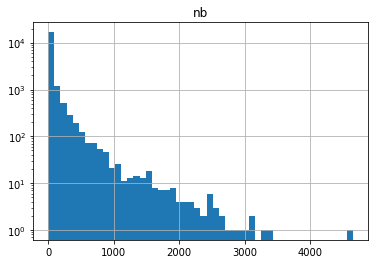

In [141]:
means_consumptions.hist(column='nb', bins=50, log=True) # [means_consumptions.nb <= 50]

In [164]:
diffs = means_consumptions_enough_data.groupby('product_id').apply(my_max).to_frame('max')

In [165]:
diffs['min'] = means_consumptions_enough_data.groupby('product_id').apply(my_min)

In [166]:
diffs['max_var'] = means_consumptions_enough_data.groupby('product_id').apply(my_max_var)

In [167]:
diffs.head()

,max,min,max_var
product_id,,,
1,0.246283,0.171455,0.074956
25,0.144480,0.091511,0.029359
32,0.161067,0.143185,0.031396
77,0.092170,0.092170,0.019334
93,0.170782,0.118825,0.036312


In [168]:
diffs['ecart'] = (diffs['max'] - diffs['min']) / np.sqrt(diffs['max_var'])

In [169]:
diffs.sort_values('ecart', ascending=False)

,max,min,max_var,ecart
product_id,,,,
31651,0.633436,0.277773,0.103308,1.106548
38077,0.415806,0.134431,0.105196,0.867537
39332,0.382181,0.100734,0.113076,0.836975
44517,0.361470,0.118092,0.109865,0.734265
28918,0.376559,0.143465,0.106589,0.713964
...,...,...,...,...
21784,0.103551,0.103551,0.021579,0.000000
21782,0.135911,0.135911,0.032733,0.000000
21757,0.111539,0.111539,0.031289,0.000000


In [114]:
# diffs.replace(np.inf, np.nan, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0xa4abb1550>]],
      dtype=object)

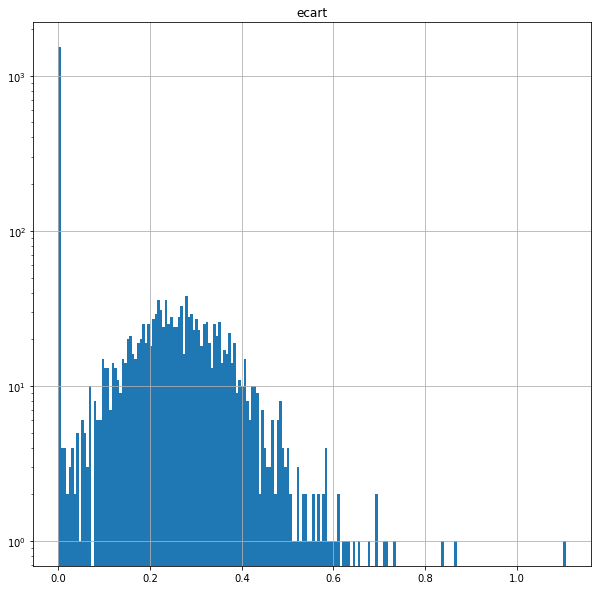

In [170]:
diffs.hist(column='ecart', bins=200, log=True, figsize=(10,10))

Conclusion: clusters do not differentiate in terms of snacks preferences. (at least when not taking into account those who do not buy snacks).

In [32]:
orders_matrix = snacks_orders_users.pivot(index='user_id', columns='product_name', values='nb_orders')
orders_matrix.head()

product_name,1 Apple + 1 Mango Fruit Bar,1 Apple + 1 Pear Fruit Bar,100 Calorie Per Bag Popcorn,100 Calorie Healthy Pop Butter 1.2 Oz Mini Bags Microwave Pop Corn,100 Calorie Healthy Pop Butter Microwave Pop Corn,100 Calorie Healthy Pop Kettle Corn Microwave Pop Corn,100 Calorie Mini Bag Butter Microwave Popcorn,100 Calorie Premium Microwave Butter Popcorn,100 Calorie Pretzels Packs,100 Calorie Right Bites Cheez It Snack Mix,...,"\""Mokaccino\"" Milk + Blue Bottle Coffee Chocolate",eat your vegetables Vegetable Chips Sour Cream & Onion,of Hanover 100 Calorie Pretzels Mini,with Xylitol Cinnamon 18 Sticks Sugar Free Gum,with Xylitol Island Berry Lime 18 Sticks Sugar Free Gum,with Xylitol Minty Sweet Twist 18 Sticks Sugar Free Gum,with Xylitol Original Flavor 18 Sticks Sugar Free Gum,with Xylitol Unwrapped Original Flavor 50 Sticks Sugar Free Gum,with Xylitol Unwrapped Spearmint 50 Sticks Sugar Free Gum,with Xylitol Watermelon Twist 18 Sticks Sugar Free Gum
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
orders_matrix = orders_matrix.fillna(value=0)

In [34]:
# fill in other users (those who did not buy any snack)
#for user_id in set(range(len(users_cluster))).difference(set(orders_matrix.index)):
#    orders_matrix.loc[user_id] = [0. for _ in range(len(orders_matrix.columns))]

In [37]:
orders_by_cluster = {}
for i in range(5):
    orders_by_cluster[i] = orders_matrix.loc[[j+1 for j in range(len(users_cluster)) if users_cluster[j] == i]]
    #orders_by_cluster[i].to_pickle('orders_by_cluster_{}'.format(i))

/Users/ariane/applications/miniconda3/envs/ada/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
# fill in other users (those who did not buy any snack)
#for i in range(5):
for user_id_minus_one, cl in enumerate(users_cluster):
    if user_id_minus_one+1 not in orders_by_cluster[cl]:
        orders_by_cluster[cl].loc[user_id_minus_one+1] = [0. for _ in range(len(orders_matrix.columns))]

In [39]:
# normalize by overall snacks consumption
# should be moved to before filling in
for cl, orders in orders_by_cluster.items():
    orders_by_cluster[cl] = orders.div(orders.sum(axis=1), axis=0)

In [52]:
import math

In [57]:
orders_by_cluster[0].head()

product_name,1 Apple + 1 Mango Fruit Bar,1 Apple + 1 Pear Fruit Bar,100 Calorie Per Bag Popcorn,100 Calorie Healthy Pop Butter 1.2 Oz Mini Bags Microwave Pop Corn,100 Calorie Healthy Pop Butter Microwave Pop Corn,100 Calorie Healthy Pop Kettle Corn Microwave Pop Corn,100 Calorie Mini Bag Butter Microwave Popcorn,100 Calorie Premium Microwave Butter Popcorn,100 Calorie Pretzels Packs,100 Calorie Right Bites Cheez It Snack Mix,...,"\""Mokaccino\"" Milk + Blue Bottle Coffee Chocolate",eat your vegetables Vegetable Chips Sour Cream & Onion,of Hanover 100 Calorie Pretzels Mini,with Xylitol Cinnamon 18 Sticks Sugar Free Gum,with Xylitol Island Berry Lime 18 Sticks Sugar Free Gum,with Xylitol Minty Sweet Twist 18 Sticks Sugar Free Gum,with Xylitol Original Flavor 18 Sticks Sugar Free Gum,with Xylitol Unwrapped Original Flavor 50 Sticks Sugar Free Gum,with Xylitol Unwrapped Spearmint 50 Sticks Sugar Free Gum,with Xylitol Watermelon Twist 18 Sticks Sugar Free Gum
user_id,,,,,,,,,,,,,,,,,,,,,
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
avg_consumption = pd.DataFrame({'0':[], '1':[], '2':[], '3':[], '4':[]})
for prod in orders_by_cluster[0].columns:
    print(orders_by_cluster[cl][prod])
    break
    avg_consumption.loc[prod] = [(orders_by_cluster[cl][prod].mean(), orders_by_cluster[cl][prod].var()) for cl in range(5)]

user_id
1        NaN
4        NaN
7        NaN
9        NaN
11       NaN
          ..
206205   NaN
206206   NaN
206207   NaN
206208   NaN
206209   NaN
Name: 1 Apple + 1 Mango Fruit Bar, Length: 98892, dtype: float64


In [48]:
avg_consumption.head(200)

,0,1,2,3,4
1 Apple + 1 Mango Fruit Bar,"(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)"
1 Apple + 1 Pear Fruit Bar,"(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)"
100 Calorie Per Bag Popcorn,"(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)"
100 Calorie Healthy Pop Butter 1.2 Oz Mini Bags Microwave Pop Corn,"(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)"
100 Calorie Healthy Pop Butter Microwave Pop Corn,"(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)"
...,...,...,...,...,...
Almond Walnut Macadamia Plus Bar,"(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)"
Almond Walnut Macadamia With Peanuts Plus Protein Bars,"(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)"
"Almond, Bunny Mix Chocolate Candies","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)"
Almonds,"(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)"


In [35]:
# run jusque là

In [37]:
from scipy.stats import f_oneway, mannwhitneyu, kruskal

In [35]:
these_users_cluster = [users_cluster[i-1] for i in orders_matrix.index]

In [39]:
for prod, vals in orders_matrix.iteritems():
    print(vals)
    #f_oneway(orders_matrix[orders_matrix.cluster==])
    break

user_id
1         0.0
2         0.0
3         0.0
4         0.0
5         0.0
         ... 
206204    0.0
206206    0.0
206207    0.0
206208    0.0
206209    0.0
Name: 1 Apple + 1 Mango Fruit Bar, Length: 174219, dtype: float64


# Basic Statistical analysis

A first way to get familiar with the data we have to treat is to derive basic statistics between features. In this part, we do so by joining our 5 datasets and ploting distributions.

### Number of products per Aisle and Department (products diversity)

We first visualize the products per aisle and per department to detect any inconsistency

In [18]:
per_dpt=products_litteral[['product_id', 'department']].groupby('department').count().sort_values(by='product_id', ascending=False)
per_dpt.columns=['COUNT']

Text(0, 0.5, 'Departments')

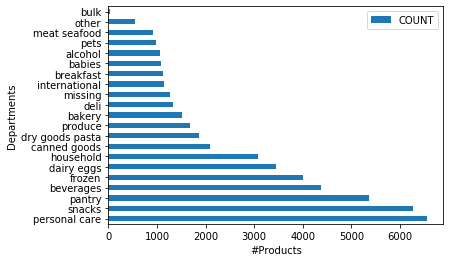

In [19]:
ax = per_dpt.plot(kind='barh')
ax.set_xlabel('#Products')
ax.set_ylabel('Departments')

In [20]:
per_dpt.head()

,COUNT
department,
personal care,6563
snacks,6264
pantry,5371
beverages,4365
frozen,4007


The 'personal care' department has the largest choice of products, just followed by the 'snacks' one.

In [21]:
per_aisle=products_litteral[['product_id', 'aisle']].groupby('aisle').count().sort_values(by='product_id', ascending=False)
per_aisle.columns=['COUNT']


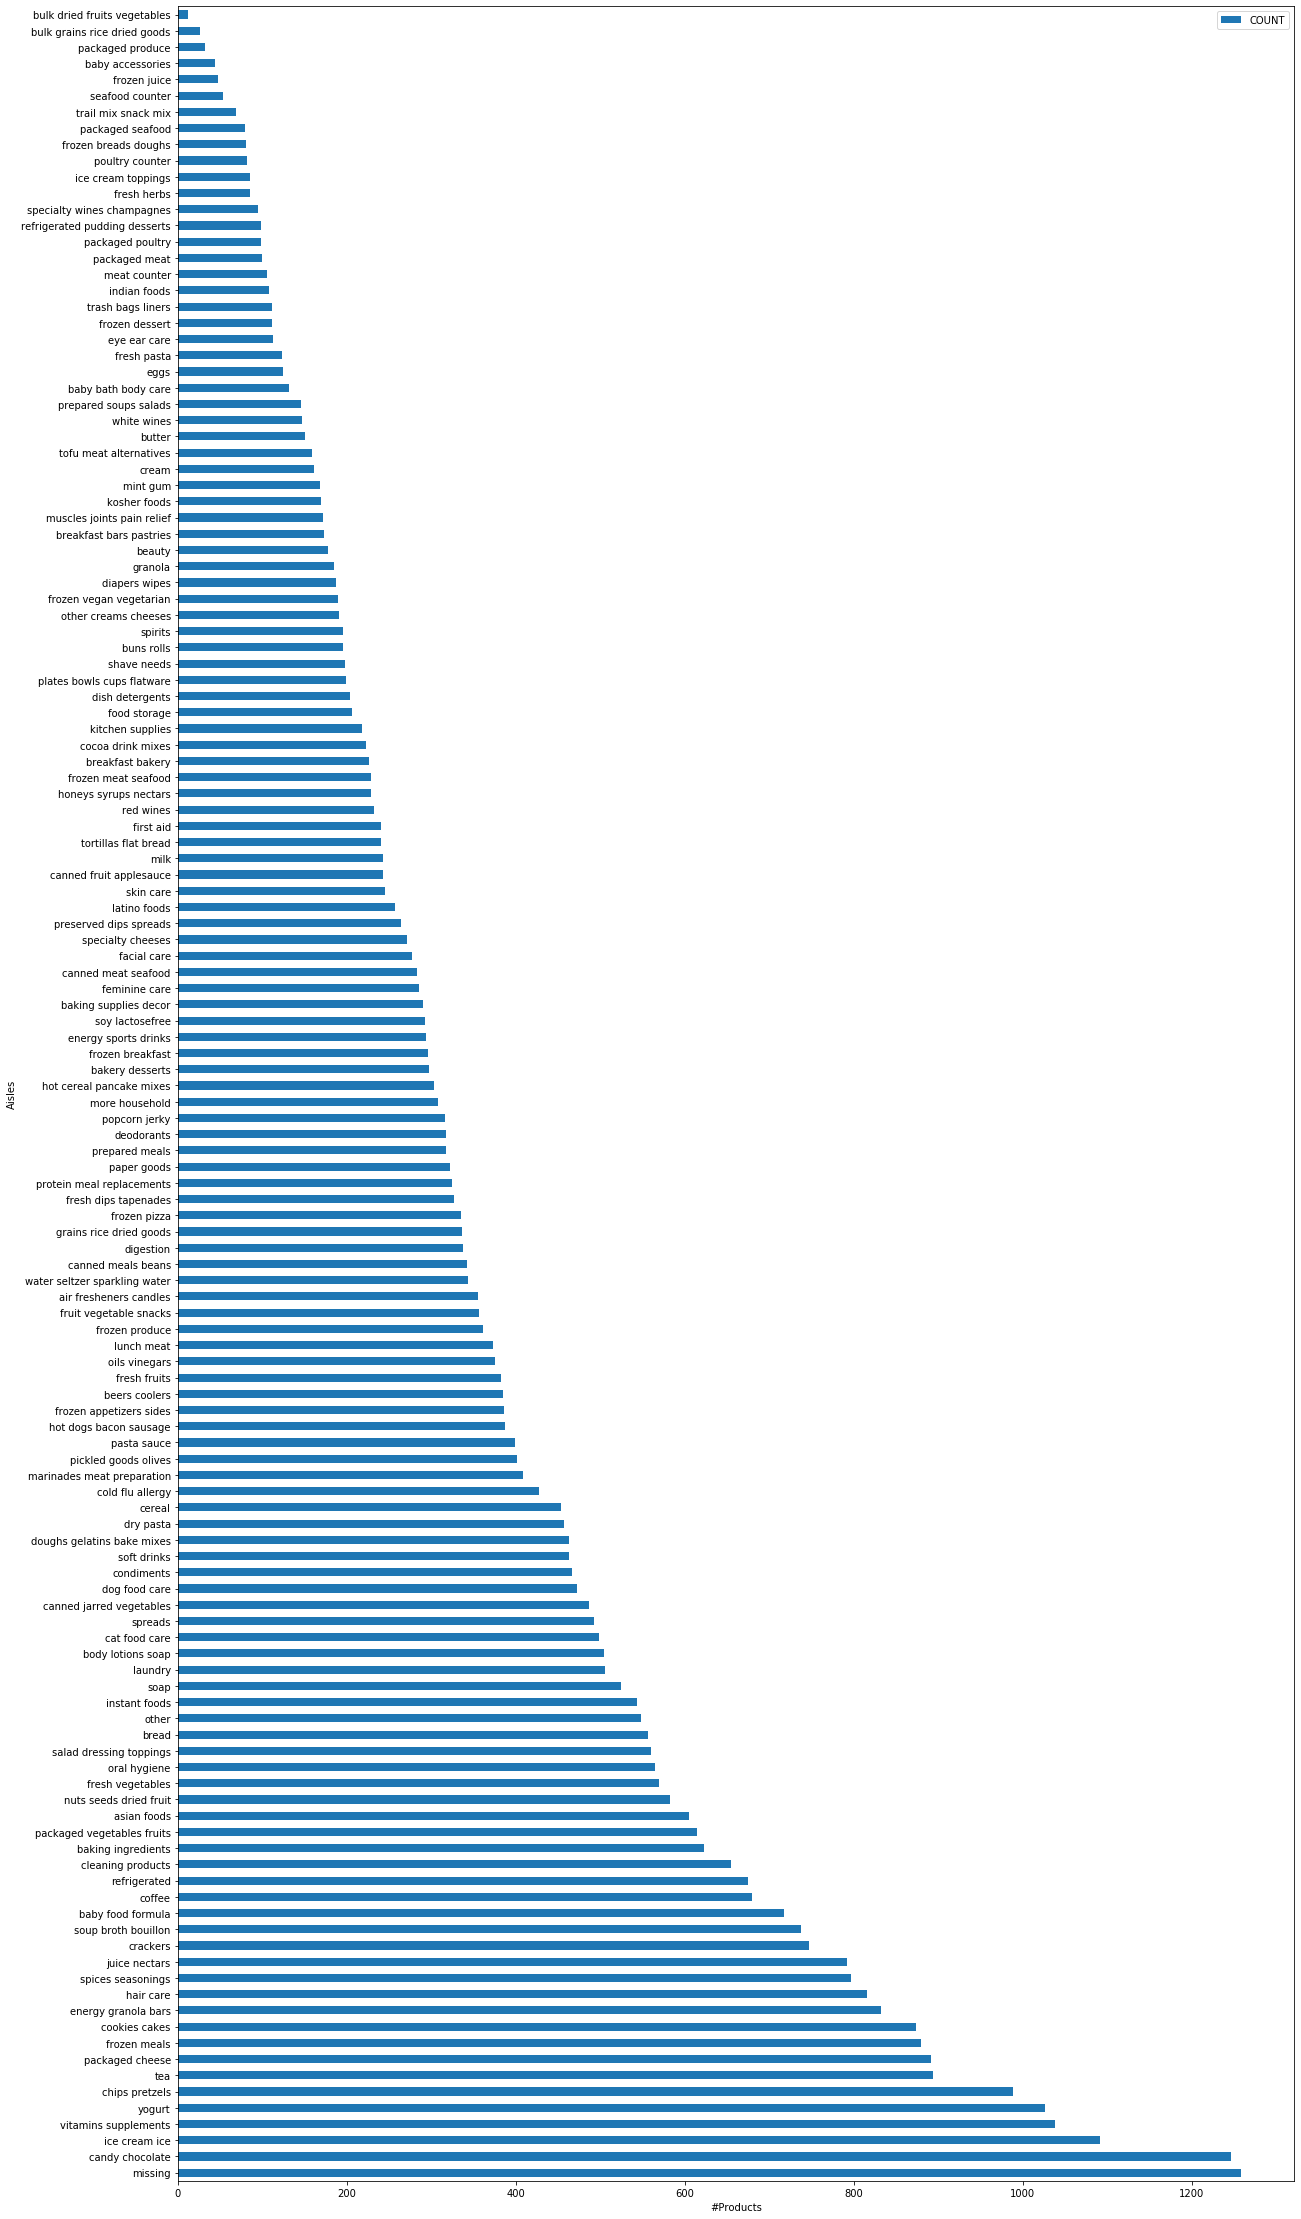

In [22]:
ax = per_aisle.plot(kind='barh', figsize=(20,40))
ax.set_xlabel('#Products')
ax.set_ylabel('Aisles')
plt.show()

In [23]:
per_aisle.head()

,COUNT
aisle,
missing,1258
candy chocolate,1246
ice cream ice,1091
vitamins supplements,1038
yogurt,1026


'Candy chocolate' and 'ice cream ice' have the largest choices of products. We can see that none of the 10 first aisles are in the 'Personal care' departement. However, this department is the lagest in terms of products number because it offers a diverse choice of aisles instead of one aisle with many products, as 'Snacks'.

### Number of orders

Let's complete our 'useful' dataset with the information about the number of orders per product

In [24]:
number_of_order_per_product = history[['order_id','product_id']].groupby('product_id').count().sort_values(by='order_id', ascending=False)
number_of_order_per_product = number_of_order_per_product.rename(columns={"order_id" : "number_of_orders"})
number_of_order_per_product.head()

,number_of_orders
product_id,
24852,472565
13176,379450
21137,264683
21903,241921
47209,213584


In [25]:
products_litteral.head()

,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks
2,102,Danish Butter Cookies,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks


In [26]:
number_of_order_per_product.head()

,number_of_orders
product_id,
24852,472565
13176,379450
21137,264683
21903,241921
47209,213584


In [27]:
products_litteral = pd.merge(products_litteral, number_of_order_per_product, on='product_id')
products_litteral.head()

,product_id,product_name,aisle,department,number_of_orders
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks,1852
1,78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks,11
2,102,Danish Butter Cookies,cookies cakes,snacks,185
3,172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks,97
4,285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks,156


**Number of orders per product**

In [28]:
products_litteral.sort_values(by='number_of_orders', ascending=False).head()

,product_id,product_name,aisle,department,number_of_orders
42491,24852,Banana,fresh fruits,produce,472565
42399,13176,Bag of Organic Bananas,fresh fruits,produce,379450
42466,21137,Organic Strawberries,fresh fruits,produce,264683
41417,21903,Organic Baby Spinach,packaged vegetables fruits,produce,241921
42662,47209,Organic Hass Avocado,fresh fruits,produce,213584


Bananas are the most sold product.

Text(0.5, 0, 'Departments')

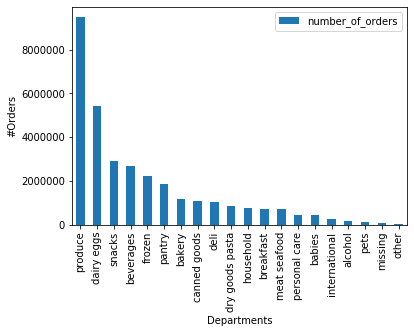

In [29]:
order_by_department = products_litteral[['department', 'number_of_orders']].groupby('department').sum().sort_values(by='number_of_orders', ascending=False).head(20)
ax = order_by_department.plot(kind='bar')
ax.set_ylabel('#Orders')
ax.set_xlabel('Departments')

Text(0.5, 0, 'Aisles')

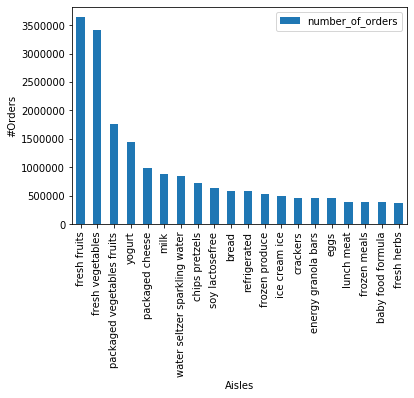

In [30]:
order_by_aisle = products_litteral[['aisle', 'number_of_orders']].groupby('aisle').sum().sort_values(by='number_of_orders', ascending=False).head(20)
ax = order_by_aisle.plot(kind='bar')
ax.set_ylabel('#Orders')
ax.set_xlabel('Aisles')

Produce, followed by eggs are the departments with most sales. For the aisles, it is fresh fruits and vegetables that take the lead. Interestingly, snacks, which is the aisle with mostthe largest choice of products, is only the third in number of sales.

### Timing of orders

In [31]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [32]:
days_of_orders = orders[['order_id', 'order_dow']].groupby('order_dow').count()
days_of_orders = days_of_orders.rename(columns={"order_id" : "number_of_orders"})
days_of_orders

,number_of_orders
order_dow,
0,600905
1,587478
2,467260
3,436972
4,426339
5,453368
6,448761


In [33]:
days_of_orders.index = ['Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']

We found in some metadata that 0 corresponds to Saturday. This is not surprising as we expect that customers have more time to purchase during weekends.

Text(0, 0.5, '#Orders')

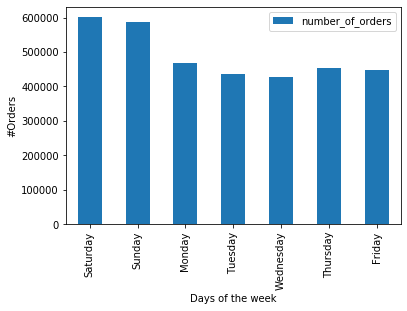

In [34]:
ax = days_of_orders.plot(kind='bar')
ax.set_xlabel('Days of the week')
ax.set_ylabel('#Orders')

Text(0, 0.5, '#Orders')

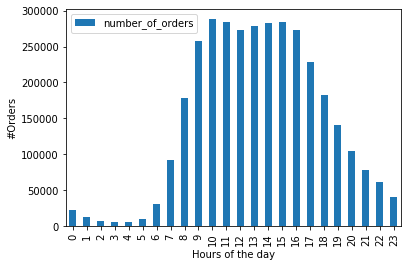

In [35]:
hours_of_orders = orders[['order_id', 'order_hour_of_day']].groupby('order_hour_of_day').count()
hours_of_orders = hours_of_orders.rename(columns={"order_id" : "number_of_orders"})
ax = hours_of_orders.plot(kind='bar')
ax.set_xlabel('Hours of the day')
ax.set_ylabel('#Orders')

People tend to order during working hours (between 8 a.m. and 20 p.m.), and at the beginning of the week (Monday and Tuesday).

### Multiple orders

Text(0, 0.5, '#of such orders')

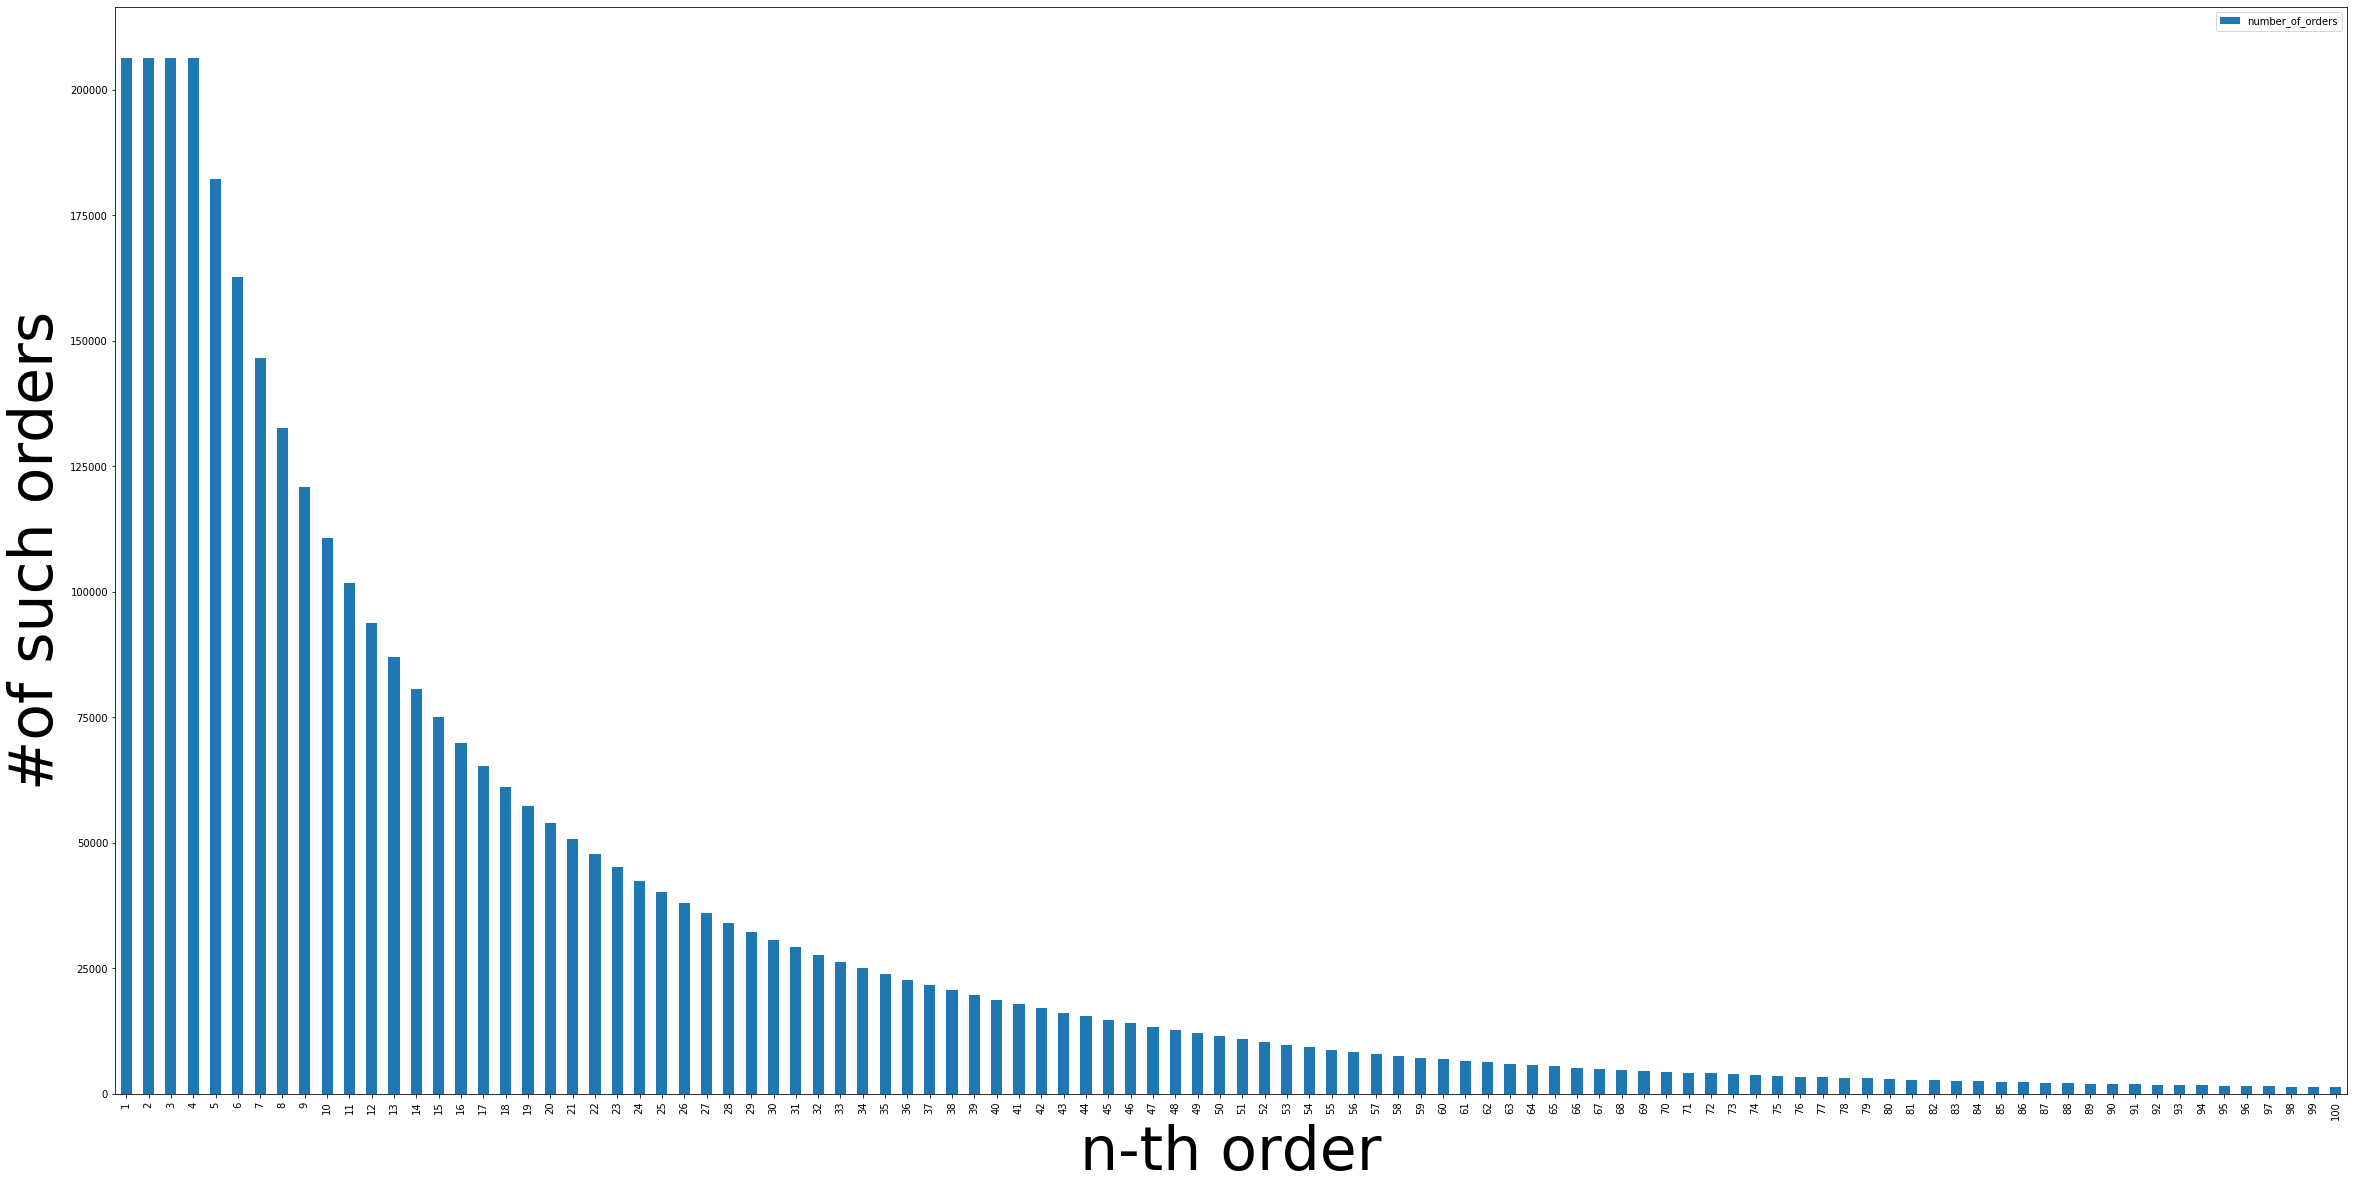

In [36]:
number_of_orders = orders[['order_id', 'order_number']].groupby('order_number').count() #Order_number represents the number of the order with respect to a particular customer
number_of_orders = number_of_orders.rename(columns={"order_id" : "number_of_orders"})
ax = number_of_orders.plot(kind='bar', figsize=(40,20))
ax.set_xlabel('n-th order',fontsize=60)
ax.set_ylabel('#of such orders',fontsize=60)

Most of the orders are first-time orders. We can see it from a different perspective with an user-centric approach.

In [37]:
max_orders = orders[['user_id', 'order_number']].groupby('user_id').max()
max_orders = max_orders.rename(columns={"order_number" : "max_orders"})

Text(0, 0.5, '#Users')

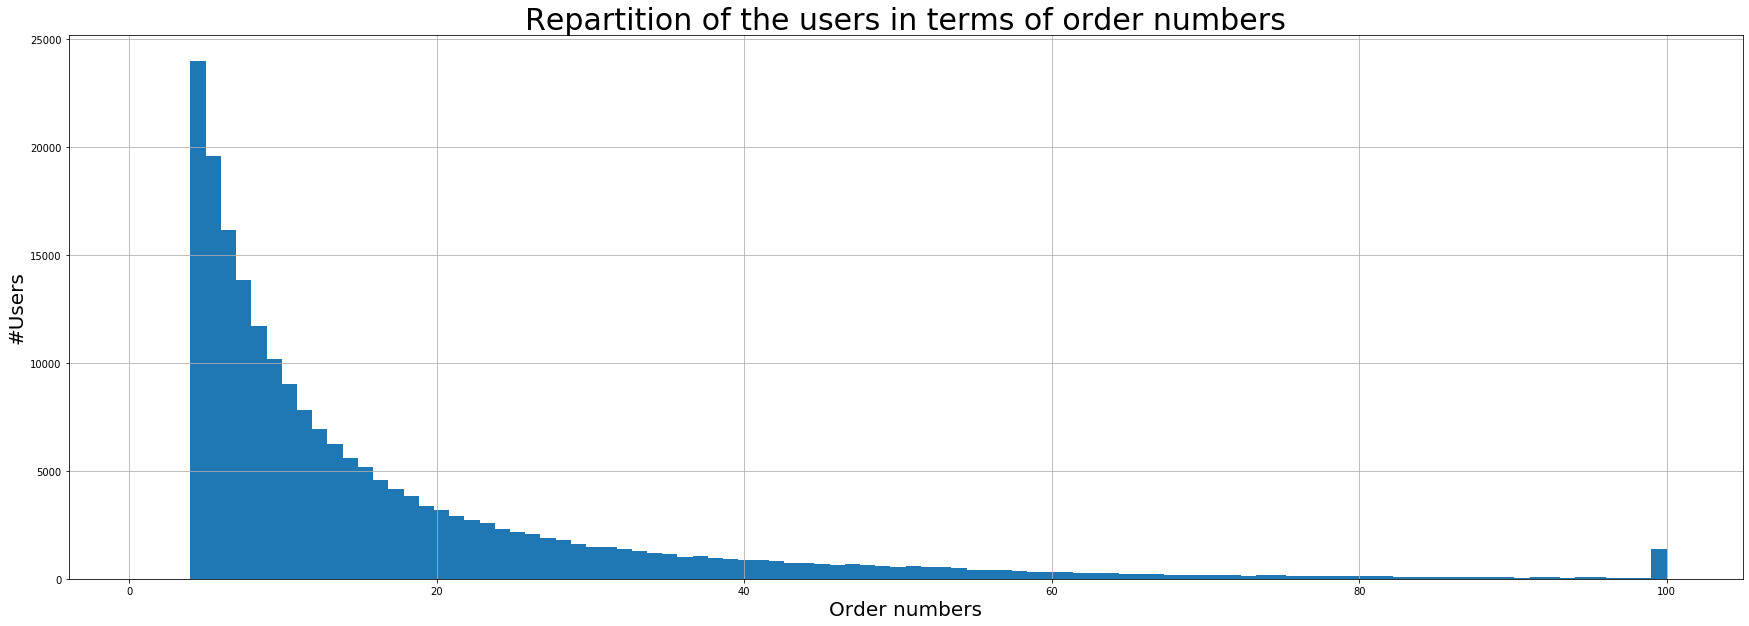

In [38]:
m = int(max_orders.max())
max_orders.hist(range=(1, m), bins = m, figsize=(30,10))
plt.title('Repartition of the users in terms of order numbers',fontsize=30)
plt.xlabel('Order numbers',fontsize=20)
plt.ylabel('#Users',fontsize=20)

Most of the consumers only order 4 times. None of them order less, which is surprising. We can hypothesize that we were provided with a dataset containing only user data , and the distribution is then logarithmic We can see a high pic at 100 orders, which probably correspond to "100 and more". 

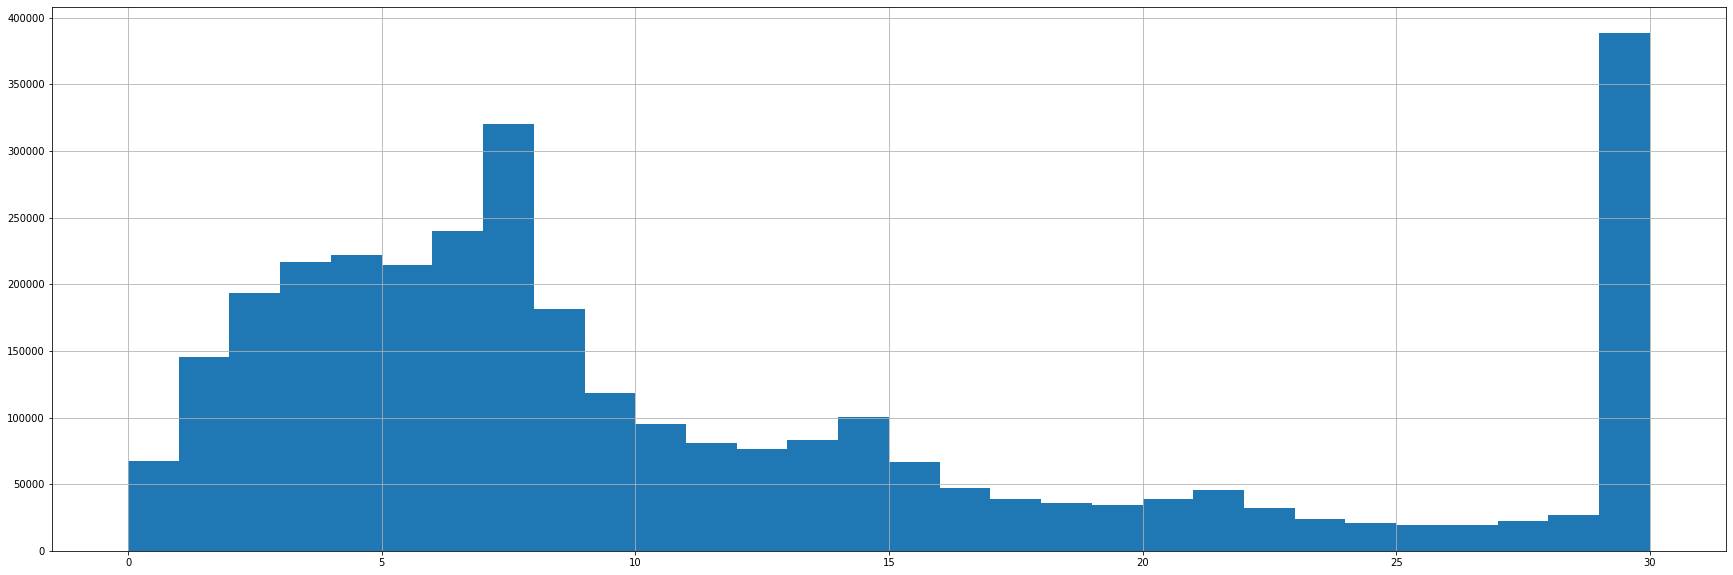

In [39]:
m = int(orders['days_since_prior_order'].max())
orders['days_since_prior_order'].hist(bins = m, figsize=(30,10))

We can see a high pick in "30 days", which probably corresponds to "30 and more", thus unregular users. Otherwise, most consumer reorder within 10 days and we can see a pick in 7 days. This means many users order at the same day of he week.

### Reordering

We finally want to merge our history and orders datasets to gather all informations about reordering. This is the final dataset we'll use.

In [40]:
history.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [41]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [42]:
history_users = pd.merge(history, orders, on='order_id')
history_users.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


In [43]:
history_users.to_pickle('history_users')